In [24]:
class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        
        # Conv
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Feed into GRU.
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # WEIGHT SHARING??
        self.decoder.weight = self.fc3.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # Conv
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # Feed into GRU.
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [1]:
import time

import cv2
import numpy as np
import pandas as pd
import pt_util
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
DATA_PATH = '/home/wangc21/datasets/ARC/right_loop/'
#DATA_PATH = '/home/wangc21/datasets/ARC/left_loop/'

In [3]:
class ARCDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        df_labels = pd.read_csv(data_path + 'labels.csv', sep=',', header=None)
        self.labels = df_labels.values.astype(np.float32)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        # process color frame, using defined augmentations
        image = cv2.imread(self.data_path + 'images/' + str(idx) + '.jpg')
        if self.transform:
            image = self.transform(image)
        
        # process depth data, convert to tensor
        depth = cv2.imread(self.data_path + 'depth/' + str(idx) + '.jpg', 0)
        depth = transforms.ToTensor()(depth)
        
        # concat with color frame
        concat = torch.cat((image, depth))
        return (concat, self.labels[idx])

In [12]:
# Perform data augmentation only on color frames, but not depth data.

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

data_train = ARCDataset(DATA_PATH + 'train/', transform=train_transforms)
print(len(data_train))
data_test = ARCDataset(DATA_PATH + 'val/', transform=test_transforms)
print(len(data_test))

3200
800


In [13]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: ' + str(test_loss) + '\n')
    return test_loss

In [6]:
# Baseline Model
# RL Epoch 35 loss: 0.009380207437316131 
# LL Epoch 42 loss: 0.012472578078159132

class CaeLeNet(nn.Module):
    def __init__(self):
        super(CaeLeNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.fc1 = nn.Linear(80*60*256, 100)
        self.fc2_1 = nn.Linear(100, 1)
        self.fc2_2 = nn.Linear(100, 1)
        self.drop = nn.Dropout(0.1)
        
        self.lowest_error = float("inf")
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 80*60*256)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        throttle = self.fc2_1(x)
        angle = self.fc2_2(x)
        return torch.cat((throttle, angle), 1)
        
    def loss(self, prediction, label, reduction='mean'):
        loss = F.mse_loss(prediction, label, reduction = reduction)
        return loss
    
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, error, file_path, num_to_keep=1):
        if error < self.lowest_error:
          self.lowest_error = error
          pt_util.save(self, file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [14]:
# Epoch 61 loss: 0.010190203980746446

class Darknet(nn.Module):
    def __init__(self):
        super(Darknet, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv6 = nn.Conv2d(256, 512, 3, 1, 1)
        self.conv7 = nn.Conv2d(512, 1024, 3, 1, 1)
        self.fc_1 = nn.Linear(5*3*1024, 1)
        self.fc_2 = nn.Linear(5*3*1024, 1)
        
        self.lowest_error = float("inf")
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*3*1024)
        throttle = self.fc_1(x)
        angle = self.fc_2(x)
        return torch.cat((throttle, angle), 1)
        
    def loss(self, prediction, label, reduction='mean'):
        loss = F.mse_loss(prediction, label, reduction = reduction)
        return loss
    
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, error, file_path, num_to_keep=1):
        if error < self.lowest_error:
          self.lowest_error = error
          pt_util.save(self, file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num cpus: 16

Test set: Average loss: 0.2127537901699543

Tue Dec  3 22:15:06 2019 Train Epoch: 0 [0/3200 (0%)]	Loss: 0.085617
Tue Dec  3 22:15:11 2019 Train Epoch: 0 [1000/3200 (31%)]	Loss: 0.024323
Tue Dec  3 22:15:17 2019 Train Epoch: 0 [2000/3200 (62%)]	Loss: 0.022156
Tue Dec  3 22:15:22 2019 Train Epoch: 0 [3000/3200 (94%)]	Loss: 0.019126

Test set: Average loss: 0.04911190269631334

Saved /home/wangc21/datasets/ARC/right_loop/checkpoints/000.pt

Tue Dec  3 22:15:28 2019 Train Epoch: 1 [0/3200 (0%)]	Loss: 0.018941
Tue Dec  3 22:15:33 2019 Train Epoch: 1 [1000/3200 (31%)]	Loss: 0.028476
Tue Dec  3 22:15:38 2019 Train Epoch: 1 [2000/3200 (62%)]	Loss: 0.021773
Tue Dec  3 22:15:43 2019 Train Epoch: 1 [3000/3200 (94%)]	Loss: 0.014100

Test set: Average loss: 0.01969750061594823

Saved /home/wangc21/datasets/ARC/right_loop/checkpoints/001.pt

Tue Dec  3 22:15:48 2019 Train Epoch: 2 [0/3200 (0%)]	Loss: 0.011559
Tue Dec  3 22:15:54 2019 Train Epoch: 2 [1000/3200 (31%)]	L

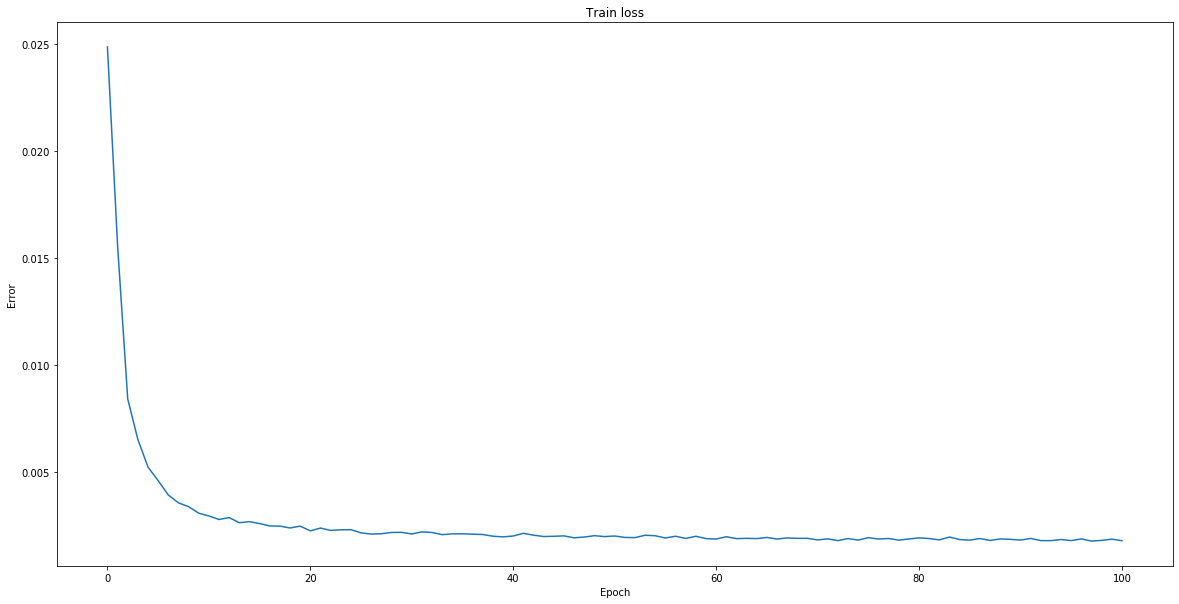

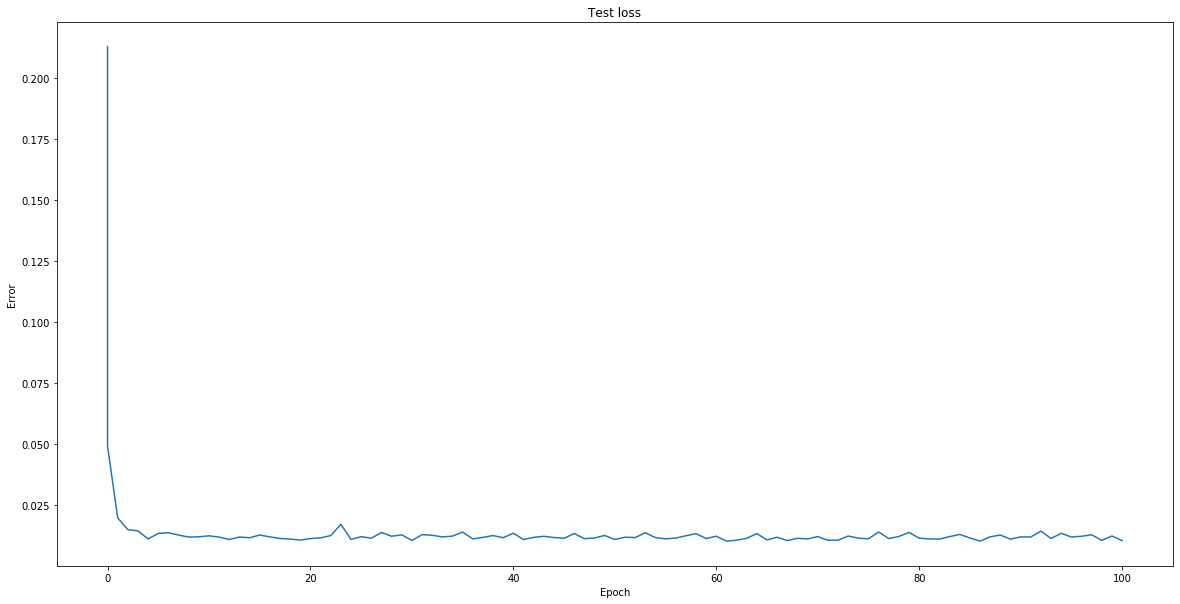

In [15]:
BATCH_SIZE = 10
TEST_BATCH_SIZE = 5
EPOCHS = 100
LEARNING_RATE = 0.001
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
LOG_PATH = DATA_PATH + 'log.pkl'

use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

#model = CaeLeNet().to(device)
model = Darknet().to(device)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
#start_epoch = 0

train_losses, test_losses = pt_util.read_log(LOG_PATH, ([], []))
test_loss = test(model, device, test_loader)
test_losses.append((start_epoch, test_loss))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses))
        model.save_best_model(test_loss, DATA_PATH + 'checkpoints/%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')